### Assignment 5 
Implementation of a Tabular Q-learning agent and an MLP based Neural Q-learning agent 

Authors: Abdullahi Ali, Pieter Wolfert

In [236]:
from my_env import EvidenceEnv
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
plt.style.use('ggplot')

Definition of an agent that picks random actions. Given in the assignment. 

In [237]:
class RandomAgent(object):

    def __init__(self, env):
        self.env = env

    def act(self, observation):
        return np.random.choice(self.env.n_action)

    def train(self, a, old_obs, r, new_obs):
        pass        

Training loop for the random agent. Again given in the assignment

In [238]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
agent = RandomAgent(env)
#reset environment and agent
obs = env.reset()
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    #no training involved for random agent
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)

### Assignment 1 
Plot of the cumulative reward. As can be seen in from the plot, the cumulative reward heavily fluctuates over time. This is to be expected form an agent with random behaviour.

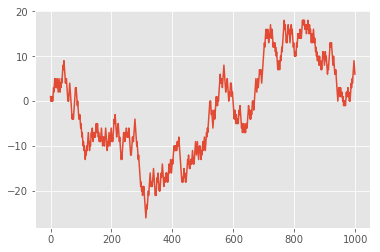

In [239]:
plt.plot(R)
plt.show()

### Assignment 2: Tabular Q-learning Agent
Implementation of tabular Q-learning. We initialise the Q-table with random numbers when creating the agent. The learning rate (lr) was determined by trying out several values and see what worked best. The discount factor (gamma) is based on the blog:  http://neuro.cs.ut.ee/demystifying-deep-reinforcement-learning/.

In [240]:
class TabularAgent(object):

    def __init__(self, env):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.2
        self.gamma = 0.9
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_Q = self.Q[old_obs, a]
        self.Q[old_obs, a] = self.Q[old_obs, a] + \
            self.lr*(r + self.gamma*(self.Q[new_obs, self.act(new_obs)]) - self.Q[old_obs, a])

#### Training
Training loop for learning Q-values for the Tabular Q-learning agent. We use the same parameters as in the random case (1000 iterations n=2 and p=0.95). For every iteration, the agent carries out an action, observes a reward and a new state and uses this information to update the Q-value.

In [241]:
# number of iterations
n_iter = 1000
#environment specs
tab_env = EvidenceEnv(n=2, p=0.95)
agent = TabularAgent(tab_env)
Q_before = agent.get_Q()
obs = tab_env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = tab_env.step(action)
    _obs = tab_env.asint(_obs)
    agent.train(action, obs, r, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

Plot of the cumulative reward. This plot shows a linear increase in reward over iterations, which means that the agent mostly picks succesfull actions at each state and proves that it learns to accumulate rewards over time.

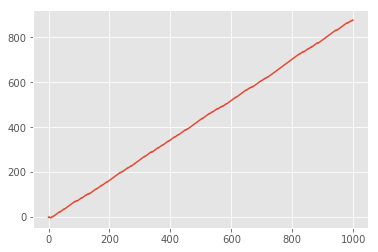

In [242]:
plt.plot(R)
plt.show()

Plot of the Q values before and after learning. 

<function matplotlib.pyplot.show>

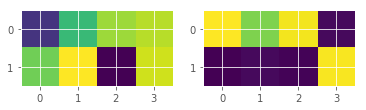

In [243]:
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show

### Assignment 3
Implementation of NeuralQAgent. NeuralQAgent takes a classifier, which predicts the Q-values on the basis of the observations. This version can now act without doing look ups in a table. Which is more efficient. Note that we still keep track of a Q-table for plotting Q-values, since it's feasible in this problem, but it's not nessecary. 

In [251]:
class NeuralQAgent(object):

    def __init__(self, env, model, classifier, optimizer):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.10
        self.gamma = 0.9
        self.model = model
        self.classifier = classifier
        self.optimizer = optimizer
        
    def act(self, observation):
        observation = np.array(observation).astype('float32')
        prediction = self.classifier(observation).data
        return np.argmax(prediction[1])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_obs, new_obs = np.array(old_obs).astype('float32'), np.array(new_obs).astype('float32')
        self.classifier.cleargrads()
        predictionMaxQ = np.max(self.classifier(new_obs).data)
        Qtarget = r + self.gamma*predictionMaxQ
        targets = np.zeros((self.env.n_action)).astype('float32')
        targets[a] = Qtarget
        y = classifier(old_obs).data[1].astype('float32')
        self.Q[self.env.asint(old_obs), a] = y[a]
        loss = 0.5*F.sum(F.squared_error(y, targets))
        loss.backward()
        self.optimizer.update()

#### Network Structure
Chainer is used to define the structure for the MLP.

In [252]:
class MLP(Chain):
    """
    
    Implementation of a 3-layer Multilayer Perceptron
    
    """
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Hidden layer
            self.l2 = L.Linear(n_units, n_out) # Output layer
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        output = self.l2(h1)
        return output
  
class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x):
        x = F.expand_dims(x,1)
        y = self.predictor(x)
        return y

#### Training
An MLP learns the Q value (optimal policy). 

In [253]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
model = MLP(2, 2)
classifier = Regressor(model)
optimizer = optimizers.Adam()
optimizer.setup(classifier)
agent = NeuralQAgent(env, model, classifier, optimizer)
#reset environment and agent
Q_before = agent.get_Q()
obs = env.reset()
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

#### Cumulative Reward
This plot shows the cumulative reward (summation of rewards over time). Like the Tabular Agent this networks learns to accumulate rewards over time, but the performance is not as stable over each training session. 

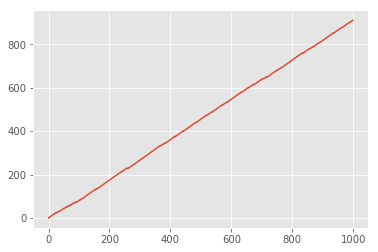

In [254]:
plt.plot(R)
plt.show()

This plot shows the randomized Q values (Q_before) and the learned Q values (Q_after).

<function matplotlib.pyplot.show>

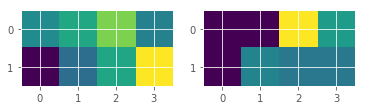

In [255]:
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show